In [ ]:
import sys
!{sys.executable} -m pip install tensorflow==2.5.0 logomaker networkx

In [1]:
import os
import numpy as np
import msa_hmm
from matplotlib import pyplot as plt

## MSA HMM Interactive

1. Fit n models, keep the best and align
2. Compare to a reference
3. Visualize the HMM

Change the variables in the following cell to fit your needs.

In [2]:
# your fasta file with unaligned sequences
train_filename = "test/data/bowman.fasta"
# if your file already contains gaps, change this flag to let them be removed
train_file_contains_gaps = False
# reference file with aligned sequences that have matching IDs to seqs in the train_file
# replace with empty string if no reference is available
ref_filename = "test/data/bowman.ref"
# number of independently trained models
num_runs = 1

## Training

In [3]:
# load the file
fasta_file = msa_hmm.fasta.Fasta(train_filename, 
                                 gaps=train_file_contains_gaps, 
                                 contains_lower_case=True)  
# optionally load the reference and find the corresponding sequences in the train file
if ref_filename != "":
    ref_fasta = msa_hmm.fasta.Fasta(ref_filename, gaps=True, contains_lower_case=True)
    subset = np.array([fasta_file.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
else:
    subset = None
results = msa_hmm.align.fit_and_align_n(num_runs,
                                        fasta_file, 
                                        config=msa_hmm.config.default,
                                        subset=subset)
best = np.argmax([ll for ll,_ in results])
best_ll, best_alignment = results[best]
print("Computed alignments with likelihoods:", [ll for ll,_ in results])
print("Best model has likelihood:", best_ll)
out_filepath = "test/data/interactive.alignment.fasta"
best_alignment.to_file(out_filepath)
if ref_filename != "":
    out_file = msa_hmm.fasta.Fasta(out_filepath, 
                             gaps=True, 
                             contains_lower_case=True) 
    _,r = out_file.precision_recall(ref_fasta)
    tc = out_file.tc_score(ref_fasta)
    print("SP score =", r, "TC score =", tc)

Training of 1 independent models on file bowman.fasta
Configuration:
transition_init : {'begin_to_match': <msa_hmm.Configuration.EntryInitializer object at 0x7fdfac1a0fd0>, 'match_to_end': <msa_hmm.Configuration.ExitInitializer object at 0x7fdfac1a28b0>, 'match_to_match': <msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fdfac1a2820>, 'match_to_insert': <msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fdfcdfad8b0>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fdfcdfad280>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fdfcdfad340>, 'match_to_delete': <msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fdfcdfad040>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fdfcdfad520>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fdfcdfade50>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fdfcdfad2b0>, 'left_

## Alignment

In [7]:
# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")

ddesskp$CCDQCACTKSNPPQCRCSDmRLNSCH$s.$ACKSCICALSYPAQCFCVDITDFCY$epckpseddken..
.sesskp$CCDQCSCTKSMPPKCRCSDiRNDFCY$..$-------------------------$epck..........
...yskp$CCDLCMCTRSMPPQCSCED.RINSCH$sd$-CKSCMCTRSQPGQCRCLDTNDFCY$kpcksr........
....ksa$CCDTCLCTKSNPPTCRCVD.VGETCH$s.$ACLSCICAYSNPPKCQCFDTQKFCY$kqchnseleevikn
.......$---SCRCTKSIPPQCHC--.------$..$-------------------------$..............


## Plot the consensus sequence logo of the trained model

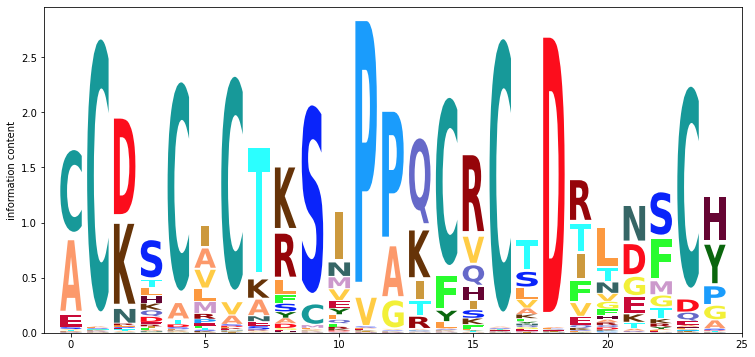

In [8]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)

## Plot the HMM plus a hidden sequence 

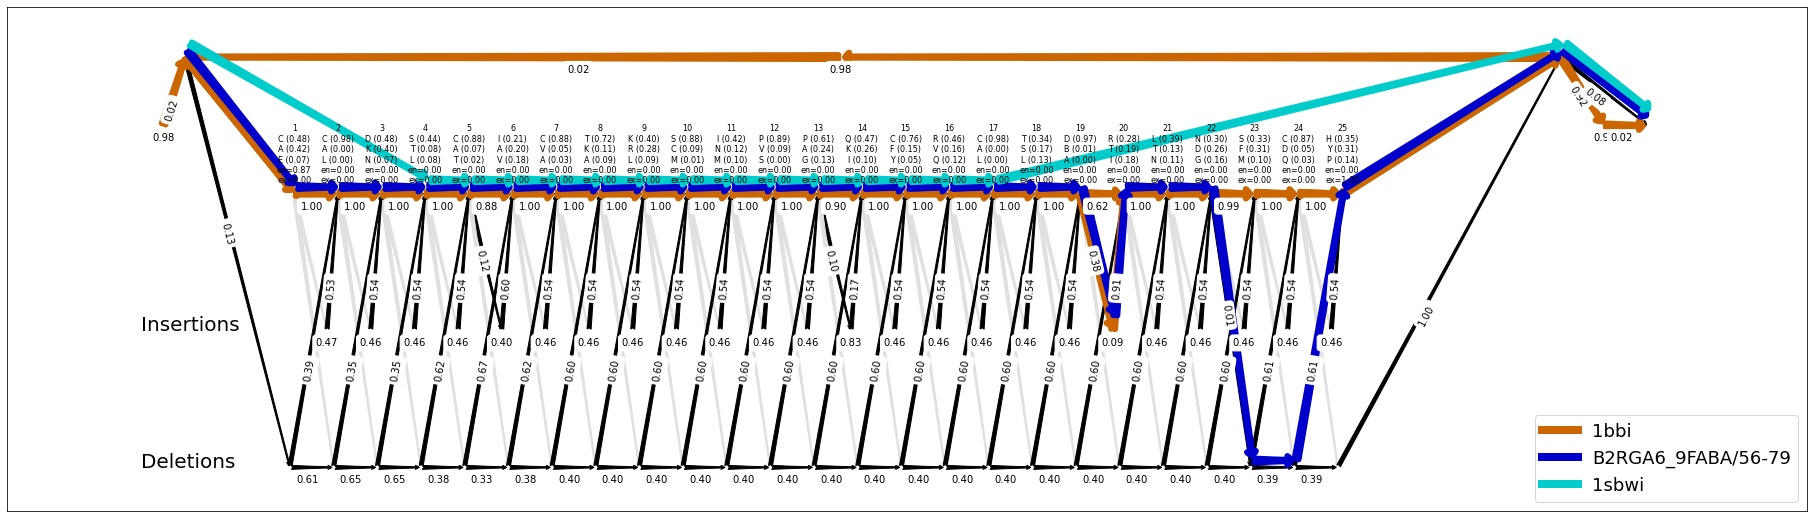

In [9]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  #full domain length
plt.savefig("bowman_viterbi.pdf", bbox_inches='tight') 